In [ ]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm.notebook import tqdm

class VariantCalling:
    def __init__(self, mutation_labels, mutation_types_names, file_name) -> None:
        self.mutation_labels = mutation_labels
        self.mutation_type_names = mutation_types_names
        self.NUCLEOTIDES = "ACGT"
        self.transdict = {"A":0, "C": 1, "G":2, "T":3}

        self.clones = []
        with open(file_name, "r") as f:
            for clone in f:
                alignment = []
                for char in clone.strip():
                    alignment.append(char)
                self.clones.append(alignment)
        self.nb_clones = len(self.clones)
        self.clones_int = self.char_to_int(self.clones)

class VariantCallingData(VariantCalling):
    """Class for simulated data generation"""
    def __init__(self,
                 mutation_labels={"no_SNP": 0, "heterozygous_SNP": 1, "homozygous_SNP": 2},
                 mutation_types_names={0: "No mutation", 1: "Heterozygous SNP", 2: "Homozygous SNP"},
                 file_name="clones.txt"
                 ) -> None:
        super().__init__(mutation_labels=mutation_labels, mutation_types_names=mutation_types_names,
                         file_name=file_name)
        self.alignments = None
        self.mutation_types = None

    def simulate_alignments(self, reference_length=200,
                        num_alignments = 2000,
                        coverage = 100,
                        mutations = None,
                        p_sequencing_error=0.0,
                        p_alignment_error=0.00) -> tuple:
        """Modified provided function to generate simulated data for the project.

        Inputs
        ------
        reference_length: Width of the image.
        num_alignments: Size of data samples (1 sample is 1 image).
        coverage: Height of the image.
        mutations: Contains the keys of the mutation types.
                    If None, use self.mutation_labels.
        p_sequencing_error: Probability of sequencing error.
        p_alignment_error: Probability of alignment error.

        Outputs
        -------
        tuple: (alignments, mutation_types)
        alignments: 3D np.array containing the data in the shape
                    (num_alignments, coverage + 1, reference_length).
        mutation_types: python list of integers indicating the mutation
                        type of each sample of data in alignments.
                        size of num_alignments.
        """
        if mutations is None:
            mutations = self.mutation_labels.keys()

        alignments = []
        mutation_types = []

        for i in range(num_alignments):
            snp_index = reference_length // 2
            if (i % 400 == 0):
                print("Computing alignment ", i)
            reference = [random.choice(self.NUCLEOTIDES) for _ in range(reference_length)]
            reference_base_at_snp = reference[snp_index]
            snp_base = random.choice([i for i in self.NUCLEOTIDES if i != reference_base_at_snp])
            mutation_type=random.choice([self.mutation_labels[m] for m in mutations])
            mutation_types.append(mutation_type)

            alignment = [reference] #first read is always the reference
            for _ in range(coverage):
                mut_index = snp_index
                new_read = [reference[i] if random.random() > p_sequencing_error
                            else random.choice(self.NUCLEOTIDES) for i in range(reference_length)]
                if random.random() < p_alignment_error:
                    mut_index = snp_index + random.randint(-1,2)
                if mutation_type == 1 and random.random() > 0.5: # heterozygous SNP
                    new_read[mut_index] = snp_base
                if mutation_type == 2: #homozygous SNP
                    new_read[mut_index] = snp_base
                if random.random() < p_sequencing_error: #Add errors to SNP region also
                    new_read[mut_index] =  random.choice(self.NUCLEOTIDES)
                alignment.append(new_read)
            alignments.append(alignment)

        self.alignments = alignments
        self.mutation_types = mutation_types
        return np.array(alignments), mutation_types


    def char_to_int(self, alignments=None) -> np.ndarray:
        """Maps the char ACGT to the corresponding integers"""
        if alignments is None:
            alignments = self.alignments
        return np.vectorize(self.transdict.get)(alignments)

    def plot_data(self, alignments_ints=None, mutation_types=None, mutation_index=0) -> None:
        """Use to plot an alignment at a certain mutation type

        Note
        ----
        This Function should be refactored, or a new function should be created
        """
        if alignments_ints is None or mutation_types is None:
            alignments_ints = self.char_to_int()
            mutation_types = self.mutation_types

        plt.rcParams['figure.dpi'] = 200
        alignment_idx = mutation_types.index(mutation_index)
        plt.title(f"Mutation type: {self.mutation_type_names[mutation_types[alignment_idx]]}")
        plt.imshow(alignments_ints[alignment_idx],cmap='jet')

    def simulate_clones(self, num_alignments = 2000,
                        coverage = 100,
                        p_sequencing_error=0.0,
                        p_alignment_error=0.00,
                        verbose=1) -> (np.ndarray, list) :
        """Wrapper to generate n alignments as specified in num_alignments.
        NOTE: Consider to merge this into simulate_alignments in the future.

        Parameters
        ----------
        num_alignments : <int>
            Number of alignments to be generated
        coverage : <int>
            Number of read for an alignment
        p_sequencing_error : <double>
            Probability of sequencing error, takes value >= 0, <= 1
        p_alignment_error : <double>
            Probability of alignment error, takes value >= 0, <= 1
        verbose : <int>
            0 - No progress will be printed
            1 - Progress will be printed for every 400 num_alignments
        Returns
        -------
        np.ndarray :
            Numpy array of alignments generated.
        list :
            List of lists of probability for each of the alignment
        """
        alignments = []
        prob_lists = []
        for i in range(num_alignments):
            if (i % int(num_alignments/20) == 0) and (verbose==1):
                print("Progress:  {progress_percentage}% completed. \tComputing alignment {current_iter} of {total_iter}".format(progress_percentage=round(i*100/num_alignments,2), current_iter = i, total_iter=num_alignments), end="\r")
            alignment, prob_list = self.ratio_gen(coverage, p_sequencing_error, p_alignment_error)
            alignments.append(alignment)
            prob_lists.append(prob_list)
        self.alignments = alignments
        print(f"Done, Number of alignments: {num_alignments}")
        return np.array(alignments), prob_lists

    def ratio_gen(self, coverage, p_sequencing_error, p_alignment_error) -> (list,list):
        """Wrapper to generate a single alignment based on a randomly generated ratio
        Returns np.ndarray of the alignment and the probability of the distribution

        NOTE: Naming of variables shall be improved in the future for easy readability

        Parameters
        ----------
        coverage : <int>
            Number of read for an alignment
        p_sequencing_error : <double>
            Probability of sequencing error, takes value >= 0, <= 1
        p_alignment_error : <double>
            Probability of alignment error, takes value >= 0, <= 1
        Returns
        -------
        list
            List of reads for an alignment
        list
            Probability distribution for the alignment read for each of the clone class
        """
        prob_dist = self._gen_prob_list(self.nb_clones, mode=2)
        nb_coverage_list = []
        for prob in prob_dist:
            nb_coverage_list.append(math.floor(prob * coverage))
        for _ in range(coverage - sum(nb_coverage_list)):
            # We randomly increase an element by 1 until we reach the number of coverages specified (n - 1)
            # as the first row is always the reference
            nb_coverage_list[random.randint(0,self.nb_clones - 1)] += 1

        coverage_list = []
        for clone_idx, nb_clone_coverage in enumerate(nb_coverage_list):
            for _ in range(0,nb_clone_coverage):
                coverage_list.append(
                    self._add_errors(self, self.clones[clone_idx],p_sequencing_error,p_alignment_error))

        # This will be the final probability list
        prob_list = [nb_coverage_list[i]/coverage for i in range(0, len(nb_coverage_list))]

        # Here we shuffle the list and concatenate into the final alignment
        choice_indices = np.random.choice(len(coverage_list), coverage, replace=False)
        alignment = [self.clones[0]] # First row is always reference (assumed to be index at 0)
        alignment += [coverage_list[i] for i in choice_indices] # Concatenate the randomized read to the reference row

        return alignment, prob_dist

    @staticmethod
    def _add_errors(self, clone, p_sequencing_error, p_alignment_error) -> list:
        """
        Adds sequencing error and alignment error to a single read, returns clone with error
        Parameters
        ----------
        clone : <List>
            List of the base-pair encoded in <int>
        p_sequencing_error : <double>
            Probability of sequencing error, takes value >= 0, <= 1
        p_alignment_error : <double>
            Probability of alignment error, takes value >= 0, <= 1

        Returns
        -------
        list
            List of bp based on input clone with sequencing and alignment errors added
        """
        # Let's make alignment error applicable to all for now
        new_clone = [clone[i] if random.random() > p_alignment_error
                     else clone[min(max(0, i + random.randint(-1,2)),len(clone)-1)] for i in range(len(clone))]
        return [new_clone[i] if random.random()> p_sequencing_error
                else random.choice(self.NUCLEOTIDES) for i in range(len(new_clone))]

    def _gen_prob_list(self, nb_class, mode=1) -> list:
        """Generate a list of nb_class elements of probability that sum to 1
        Leaving the nb_class to maintain modularity in case we need to generate
        probability for other purposes.

        Parameters
        ----------
        nb_classes : <int>
            Number of classes of probability to be generated

        mode : <int>
            Mode of the randomizer, it seems like the Dirichlet's Distribution outputs overly balanced distribution
            1 : Dirichlet's Distribution - Seems to be quite balanced, often returns within mean of p=0.33
            2 : random.random() - Generates nb_class random numbers that are normalized against the sum
        Returns
        -------
        list
            List of <nb_class> element representing the probability for each of the class.
        """
        match mode:
            case 1:
                return (np.random.dirichlet(np.ones(nb_class)*1000.,size=1)).flatten().tolist()
            case 2:
                prob_list = [random.random() for _ in range(0,nb_class)]
                return [prob_list[i] / sum(prob_list) for i in range(0, nb_class)]

    def _array_dup(self,arr,coverage) -> np.ndarray:
        """Produces an array of the reference genome repeated - this is used as a second channel in CNN, Will's Code

        Parameters
        ----------
        arr : TYPE
            Input alignment data

        coverage : TYPE
            Size of the amplicon
        coverage:

        Returns
        -------
        np.ndarray
            2-dimensional array with second channel as the reference row
        """

        # NOTE: We should be able to get size of coverage from len(arr[0]) but faced np.tile issue (the output shape is different)
        # when passing len(ref_gen) instead of coverage to np.tile, non-blocking but good to be solved in the future.
        ref_gen = arr[0]
        ref_gen_matrix = np.tile(ref_gen,(coverage,1))
        aln_ref_dim = np.array((arr, ref_gen_matrix))
        return aln_ref_dim

    def _array_dup_all(self,arr,coverage) -> np.ndarray:
        """Wrapper to call _array_dup_clone to generate channels for different clones, basically instead of only 1 channel, this wrapper
        loops and generates additional channels for all the clones considered.

        Parameters
        ----------
        arr : TYPE
            Description
        coverage : TYPE
            Description
        """

        # For each clones in the clones.txt file, we create a separate channel for it
        arr_channel = np.array([arr])
        for clone in self.clones:
            arr_channel = self._array_dup_clone(clone,arr_channel,coverage)
        return arr_channel

    def _array_dup_clone(self,clone,arr,coverage) -> np.ndarray:
        """Produces an array of the reference genome repeated, mc for multiple channel, this is built on top of Will's code and supposed to work
        better as it should work for more than one. The input parameter has been changed to specific alignment row.

        Parameters
        ----------
        clone : List
            Row of clone to be duplicate as a separate channel
        arr : List
            Input alignment data
        coverage : Int
            Size of the amplicon

        Returns
        -------
        np.ndarray
            2-dimensional array with second channel as the reference row
        """
        clone_gen_matrix = np.array([np.tile(clone,(coverage,1))])
        aln_clone_dim = np.concatenate((arr,clone_gen_matrix))
        return aln_clone_dim

    def _array_binary_mask(self,arr,coverage) -> np.ndarray:
        """Generates binary masks based on whether the base pair is the same as the reference sequence
        (0: False   1: True)

        Parameters
        ----------
        arr : <List>
            2D input list of the input array with the first row containing the reference sequence
        coverage : <int>
            Description
        """
        # Here we are transcoding the True to A as it's the highest value
        binary_transdict = {True:"T", False:"A"}
        ref_gen = arr[0]
        #binary_mask_matrix = [np.in1d(arr[i],ref_gen).tolist() for i in range(0,len(arr))]
        binary_mask_matrix = [[arr[j][i]==ref_gen[i] for i in range(0,len(arr[j]))] for j in range(0,len(arr))]
        print(binary_mask_matrix)
        binary_mask_matrix = np.vectorize(binary_transdict.get)(binary_mask_matrix)
        aln_binary_mask_dim = np.array((arr, binary_mask_matrix))
        return aln_binary_mask_dim


    def _simulate_read(self, clone_type_index: int, alignment_error_prob: float, sequencing_error_prob: float):
        sim_read = []
        copied_clone = list(self.clones[clone_type_index])  # This is so that run-time is o(n) not o(2n)
        pointer = 0
        second_alignment_error_prob = alignment_error_prob / 5  # guess work right here
        third_alignment_error_prob = alignment_error_prob /  8  # guess work right here
        forth_alignment_error_prob = alignment_error_prob /  15  # guess work right here
        while len(sim_read) < len(self.clones[clone_type_index]):
            alignment = random.uniform(0, 1)
            direction = random.choice([1, -1])
            if alignment <=  forth_alignment_error_prob:
                pointer += direction * 4
            elif alignment <= third_alignment_error_prob:
                pointer += direction * 3
            elif alignment <= second_alignment_error_prob:
                pointer += direction * 2
            elif alignment <=  alignment_error_prob:
                pointer += direction

            if pointer < 0 or pointer >= len(self.clones[clone_type_index]):
                sim_read.append(random.choice(['A', 'C', 'G', 'T']))
            else:
                sequencing = random.uniform(0,1)
                if sequencing < sequencing_error_prob:
                    current = copied_clone[pointer]
                    choice_array = ['A', 'C', 'G', 'T']
                    choice_array.remove(current)
                    copied_clone[pointer] = random.choice(choice_array)

                sim_read.append(copied_clone[pointer])

            pointer += 1
        return self.char_to_int(sim_read)

    def generate_data_for_noise_reduction(self, sample_size=1000, image_height=100, alignment_error_prob=0.05, sequencing_error_prob=0.05):
        """Function which returns noisy and non-noisy data"""

        noisy_images = []
        clean_images = []

        for _ in tqdm(range(sample_size)):
            noisy = []
            clean = []
            random_array = np.random.randint(len(self.clones), size=image_height)
            for clone_type in random_array:
                noisy.append(self._simulate_read(clone_type, alignment_error_prob, sequencing_error_prob))
                clean.append(self.char_to_int(list(self.clones[clone_type])))
            noisy_images.append(noisy)
            clean_images.append(clean)

        return np.array(noisy_images), np.array(clean_images)




In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers.legacy import Adam

In [ ]:
import pickle

In [ ]:
dg = VariantCallingData()

In [ ]:
# Check if GPU is available
if tf.config.experimental.list_physical_devices('GPU'):
    # Limit GPU memory allocation to avoid GPU memory exhaustion
    for gpu in tf.config.experimental.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPU found. Using CPU.")


In [ ]:
def create_cnn_model1(input_shape):
    input_layer = Input(shape=input_shape)

    # Encoder
    encoded = Conv2D(64, (8, 8), activation='relu', padding='same')(input_layer)
    encoded = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)

    # Decoder
    decoded = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(encoded)
    decoded = Conv2DTranspose(64, (8, 8), activation='relu', padding='same')(decoded)
    decoded = Conv2D(1, (8, 8), activation='sigmoid', padding='same')(decoded)

    model = Model(input_layer, decoded)

    return model

def create_cnn_model2(input_shape):
    input_layer = Input(shape=input_shape)

    # Encoder
    encoded = Conv2D(64, (6, 6), activation='relu', padding='same')(input_layer)
    encoded = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)

    # Decoder
    decoded = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(encoded)
    decoded = Conv2DTranspose(64, (6, 6), activation='relu', padding='same')(decoded)
    decoded = Conv2D(1, (6, 6), activation='sigmoid', padding='same')(decoded)

    model = Model(input_layer, decoded)

    return model

In [ ]:
def gen_data(align_err, seq_err):
    img_row = 100
    img_col = 178

    print(f"\ngenerating alignment error {align_err}, seq error {seq_err}")
    noisy, clean = dg.generate_data_for_noise_reduction(sample_size=15000, alignment_error_prob=align_err, sequencing_error_prob=seq_err)

    noisy = noisy.astype('float32') / 3
    clean = clean.astype('float32') / 3
    noisy = noisy.reshape(noisy.shape[0], img_row, img_col, 1)
    clean = clean.reshape(clean.shape[0], img_row, img_col, 1)
    return noisy, clean

In [ ]:
input_shape = (100, 178, 1)

model1 = create_cnn_model1(input_shape)
model2 = create_cnn_model2(input_shape)

learning_rate = 0.0005
model1.compile(optimizer=Adam(learning_rate=learning_rate), loss=MeanSquaredError())
print("\nmodel1:")
print(model1.summary())

learning_rate = 0.0005
model2.compile(optimizer=Adam(learning_rate=learning_rate), loss=MeanSquaredError())
print("\nmodel2:")
print(model2.summary())



model1:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 178, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 178, 64)      4160      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 178, 128)     73856     
                                                                 
 conv2d_transpose (Conv2DTra  (None, 100, 178, 128)    147584    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 100, 178, 64)     524352    
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 178, 1)    

In [ ]:
# Curriculum
batch_size = 64
img_row = 100
img_col = 178

curriculum = [
    {"align_err": 0, "seq_err": 0.01, "model1_epochs": 8, "model2_epochs": 4},
    {"align_err": 0, "seq_err": 0.05, "model1_epochs": 5, "model2_epochs": 3},
    {"align_err": 0.001, "seq_err": 0.05, "model1_epochs": 7, "model2_epochs": 3},
    {"align_err": 0.003, "seq_err": 0.05, "model1_epochs": 5, "model2_epochs": 3},
    {"align_err": 0.005, "seq_err": 0.05, "model1_epochs": 5, "model2_epochs": 2},
    {"align_err": 0.01, "seq_err": 0.05, "model1_epochs": 5, "model2_epochs": 2},
]

for module in curriculum:
    print("current module: ", module)
    noisy, clean = gen_data(module["align_err"], module["seq_err"])

    epochs = module["model1_epochs"]
    model1.fit(noisy, clean, batch_size=batch_size, epochs=epochs, shuffle=True)

    denoised_image1 = model1.predict(noisy)
    denoised_image1_quantised = np.round(denoised_image1 * 3) / 3

    epochs = module["model2_epochs"]
    model2.fit(denoised_image1_quantised, clean, batch_size=batch_size, epochs=epochs, shuffle=True)

current module:  {'align_err': 0, 'seq_err': 0.01, 'model1_epochs': 8, 'model2_epochs': 4}

generating alignment error 0, seq error 0.01


  0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 1/8
235/235 [==============================] - 209s 763ms/step - loss: 0.0079
Epoch 2/8
235/235 [==============================] - 180s 765ms/step - loss: 4.8176e-04
Epoch 3/8
235/235 [==============================] - 182s 776ms/step - loss: 3.0707e-04
Epoch 4/8
235/235 [==============================] - 182s 776ms/step - loss: 2.1924e-04
Epoch 5/8
235/235 [==============================] - 182s 776ms/step - loss: 1.7297e-04
Epoch 6/8
235/235 [==============================] - 182s 775ms/step - loss: 1.4703e-04
Epoch 7/8
235/235 [==============================] - 182s 776ms/step - loss: 1.2886e-04
Epoch 8/8
469/469 [==============================] - 43s 85ms/step
Epoch 1/4
235/235 [==============================] - 156s 629ms/step - loss: 0.0079
Epoch 2/4
235/235 [==============================] - 145s 617ms/step - loss: 3.7480e-04
Epoch 3/4
235/235 [==============================] - 145s 618ms/step - loss: 2.1386e-04
Epoch 4/4
235/235 [==============================] - 146s 619

  0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 1/5
235/235 [==============================] - 168s 715ms/step - loss: 3.8511e-04
Epoch 2/5
235/235 [==============================] - 179s 762ms/step - loss: 3.2808e-04
Epoch 3/5
235/235 [==============================] - 183s 777ms/step - loss: 2.9806e-04
Epoch 4/5
235/235 [==============================] - 183s 777ms/step - loss: 2.7241e-04
Epoch 5/5
469/469 [==============================] - 40s 85ms/step
Epoch 1/3
235/235 [==============================] - 144s 613ms/step - loss: 2.7636e-04
Epoch 2/3
235/235 [==============================] - 145s 616ms/step - loss: 2.7819e-04
Epoch 3/3
235/235 [==============================] - 145s 617ms/step - loss: 2.7685e-04
current module:  {'align_err': 0.001, 'seq_err': 0.05, 'model1_epochs': 7, 'model2_epochs': 3}

generating alignment error 0.001, seq error 0.05


  0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 1/7
235/235 [==============================] - 168s 716ms/step - loss: 5.9975e-04
Epoch 2/7
235/235 [==============================] - 179s 762ms/step - loss: 4.4763e-04
Epoch 3/7
235/235 [==============================] - 182s 775ms/step - loss: 3.8633e-04
Epoch 4/7
235/235 [==============================] - 183s 777ms/step - loss: 3.4235e-04
Epoch 5/7
235/235 [==============================] - 183s 778ms/step - loss: 3.1556e-04
Epoch 6/7
235/235 [==============================] - 183s 778ms/step - loss: 2.9344e-04
Epoch 7/7
469/469 [==============================] - 40s 86ms/step
Epoch 1/3
235/235 [==============================] - 144s 613ms/step - loss: 2.8119e-04
Epoch 2/3
235/235 [==============================] - 145s 617ms/step - loss: 2.7232e-04
Epoch 3/3
235/235 [==============================] - 145s 617ms/step - loss: 2.7699e-04
current module:  {'align_err': 0.003, 'seq_err': 0.05, 'model1_epochs': 5, 'model2_epochs': 3}

generating alignment error 0.003, seq error 0

  0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 1/5
235/235 [==============================] - 160s 682ms/step - loss: 0.0042
Epoch 2/5
235/235 [==============================] - 169s 719ms/step - loss: 0.0010
Epoch 3/5
235/235 [==============================] - 172s 733ms/step - loss: 7.7831e-04
Epoch 4/5
235/235 [==============================] - 173s 735ms/step - loss: 6.7560e-04
Epoch 5/5
469/469 [==============================] - 38s 81ms/step
Epoch 1/3
235/235 [==============================] - 145s 616ms/step - loss: 5.1327e-04
Epoch 2/3
235/235 [==============================] - 145s 616ms/step - loss: 5.0236e-04
Epoch 3/3
235/235 [==============================] - 145s 618ms/step - loss: 4.8920e-04
current module:  {'align_err': 0.005, 'seq_err': 0.05, 'model1_epochs': 5, 'model2_epochs': 2}

generating alignment error 0.005, seq error 0.05


  0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 1/5
235/235 [==============================] - 161s 684ms/step - loss: 0.0018
Epoch 2/5
235/235 [==============================] - 170s 721ms/step - loss: 0.0015
Epoch 3/5
235/235 [==============================] - 173s 734ms/step - loss: 0.0014
Epoch 4/5
235/235 [==============================] - 173s 736ms/step - loss: 0.0013
Epoch 5/5
469/469 [==============================] - 38s 81ms/step
Epoch 1/2
235/235 [==============================] - 145s 617ms/step - loss: 9.0671e-04
Epoch 2/2
235/235 [==============================] - 145s 617ms/step - loss: 7.7967e-04
current module:  {'align_err': 0.01, 'seq_err': 0.05, 'model1_epochs': 5, 'model2_epochs': 2}

generating alignment error 0.01, seq error 0.05


  0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 1/5
235/235 [==============================] - 159s 678ms/step - loss: 0.0142
Epoch 2/5
235/235 [==============================] - 168s 713ms/step - loss: 0.0107
Epoch 3/5
235/235 [==============================] - 171s 726ms/step - loss: 0.0099
Epoch 4/5
235/235 [==============================] - 171s 727ms/step - loss: 0.0094
Epoch 5/5
469/469 [==============================] - 38s 81ms/step
Epoch 1/2
235/235 [==============================] - 143s 609ms/step - loss: 0.0056
Epoch 2/2
235/235 [==============================] - 144s 612ms/step - loss: 0.0040


In [ ]:
# Curriculum
batch_size = 64
img_row = 100
img_col = 178

curriculum = [
    {"align_err": 0.01, "seq_err": 0.05, "model1_epochs": 10, "model2_epochs": 5},
]

for module in curriculum:
    print("current module: ", module)
    noisy, clean = gen_data(module["align_err"], module["seq_err"])

    epochs = module["model1_epochs"]
    model1.fit(noisy, clean, batch_size=batch_size, epochs=epochs, shuffle=True)

    denoised_image1 = model1.predict(noisy)
    denoised_image1_quantised = np.round(denoised_image1 * 3) / 3

    epochs = module["model2_epochs"]
    model2.fit(denoised_image1_quantised, clean, batch_size=batch_size, epochs=epochs, shuffle=True)

current module:  {'align_err': 0.01, 'seq_err': 0.05, 'model1_epochs': 10, 'model2_epochs': 5}

generating alignment error 0.01, seq error 0.05


  0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 1/10
235/235 [==============================] - 160s 681ms/step - loss: 0.0090
Epoch 2/10
235/235 [==============================] - 168s 717ms/step - loss: 0.0088
Epoch 3/10
235/235 [==============================] - 171s 727ms/step - loss: 0.0086
Epoch 4/10
235/235 [==============================] - 171s 728ms/step - loss: 0.0084
Epoch 5/10
235/235 [==============================] - 171s 729ms/step - loss: 0.0082
Epoch 6/10
235/235 [==============================] - 172s 730ms/step - loss: 0.0081
Epoch 7/10
235/235 [==============================] - 171s 729ms/step - loss: 0.0080
Epoch 8/10
235/235 [==============================] - 171s 728ms/step - loss: 0.0079
Epoch 9/10
235/235 [==============================] - 171s 730ms/step - loss: 0.0078
Epoch 10/10
469/469 [==============================] - 38s 81ms/step
Epoch 1/5
235/235 [==============================] - 143s 608ms/step - loss: 0.0031
Epoch 2/5
235/235 [==============================] - 144s 611ms/step - loss: 0.002

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model1.save('/content/drive/My Drive/model1_2')
model2.save('/content/drive/My Drive/model2_2')

In [ ]:
noisy1, clean1 = dg.generate_data_for_noise_reduction(sample_size=1, alignment_error_prob=0.003, sequencing_error_prob=0.05)
noisy1 = noisy1.astype('float32') / 3
clean1 = clean1.astype('float32') / 3
noisy1 = noisy1.reshape(noisy1.shape[0], img_row, img_col, 1)
clean1 = clean1.reshape(clean1.shape[0], img_row, img_col, 1)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
noisy_image = np.array([noisy1[-1]])

In [ ]:
denoised_image = model1.predict(noisy_image)

1/1 [==============================] - 0s 19ms/step


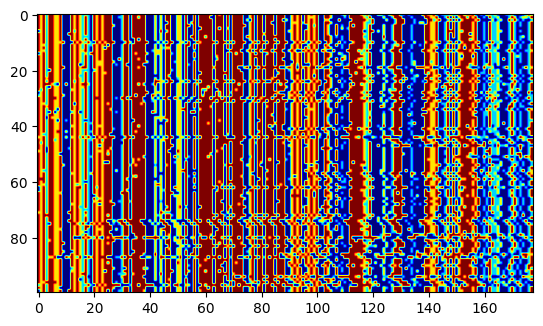

In [ ]:
plt.imshow(noisy1[0], cmap='jet')

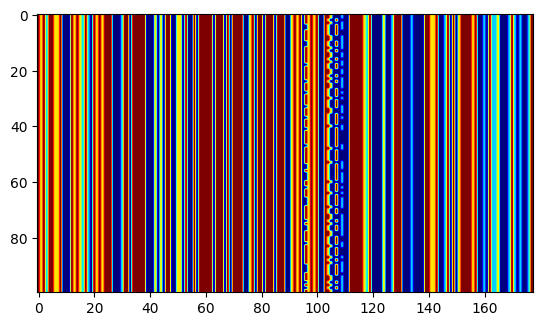

In [ ]:
plt.imshow(clean1[0], cmap='jet')

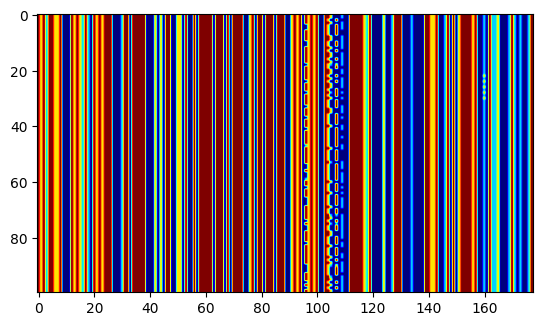

In [ ]:
plt.imshow(np.round(denoised_image[0] * 3), cmap='jet')

In [ ]:
# plt.imshow(np.round(denoised_image[0] * 3), cmap='jet')
denoised_image2 = model2.predict(np.round(np.array([denoised_image[0]]) * 3) / 3)

1/1 [==============================] - 0s 19ms/step


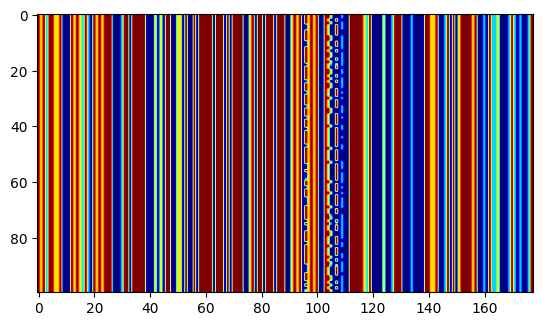

In [ ]:
plt.imshow(np.round(denoised_image2[0] * 3), cmap="jet")

In [ ]:
clone_1  = dg.char_to_int(dg.clones[0])
clone_2  = dg.char_to_int(dg.clones[1])
clone_3  = dg.char_to_int(dg.clones[2])


In [ ]:
reshaped_test_data = np.round(denoised_image2[0] * 3).reshape(100,178)

In [ ]:
clone_counter = [0,0,0,0,]
for row in reshaped_test_data:
    if (row == clone_1).all():
        clone_counter[0] += 1
    elif (row == clone_2).all():
        clone_counter[1] += 1
    elif (row == clone_3).all():
        clone_counter[2] += 1
    else:
        clone_counter[3] += 1

clone_counter

[32, 32, 26, 10]